# Deriving Quarterly NO₂ Concentration Using Pandas

This notebook explains how to transform **monthly** tropospheric NO₂ data into **quarterly** averages for multiple regions. It covers:

1. Loading the input CSV files.  
2. Standardizing region names.  
3. Normalizing and filtering HUCs (Highly Urbanized Cities).  
4. Converting units from mol/m² to µmol/m².  
5. Assigning each date to the start of its quarter.  
6. Computing quarterly means for each region.  
7. Concatenating results and saving to CSV.  
8. Visualizing the quarterly time series.  
9. Validating that all expected regions appear in the final output.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import re
from pathlib import Path
import os

In [11]:
# FOR JOJIE
# CACHE_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/cache')
# LOGS_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/logs')
# DATASET_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/dataset')

# FOR LOCAL
CACHE_DIR = Path('../_cache')
LOGS_DIR = Path('../_logs')
DATASET_DIR = Path('../datasets')

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)


## 1. Load Monthly NO₂ Datasets

We begin by loading four CSV files containing monthly NO₂ data:

In [12]:
df_city = pd.read_csv(DATASET_DIR / "no2_data" / 'PHL_HUCs_Monthly_NO2_2018_2025_JUNE3.csv')
df_province = pd.read_csv(DATASET_DIR / "no2_data" / 'PHL_Provinces_Monthly_NO2_2018_2025.csv')
df_region = pd.read_csv(DATASET_DIR / "no2_data" / 'PHL_Provinces_Monthly_NO2_2018_2025_ADD.csv')
df_hucs = pd.read_csv(DATASET_DIR / "no2_data" / 'PHL_HUCs_Monthly_NO2_2018_2025_REV2.csv')


## 2. Standardize Region Column Names

Each DataFrame uses a different column name to identify the region. We add a new column `region` to unify:

In [13]:
df_city['region'] = df_city['adm3_en']
df_province['region'] = df_province['NAME_1']
df_region['region'] = df_region['adm2_en']


Now `region` is consistent across **df_city**, **df_province**, and **df_region**.

---

## 3. Normalize and Filter HUCs Data

The HUCs DataFrame contains a `NAME_2` column with various city names. We normalize text to lowercase ASCII and then filter for specific target cities:


In [14]:
normalize = lambda x: unicodedata.normalize('NFKD', str(x)).encode('ascii', 'ignore').decode('utf-8').strip().lower()
df_hucs['NAME_2_normalized'] = df_hucs['NAME_2'].apply(normalize)

In [ ]:
target_cities = {
    'las pinas': 'City of Las Piñas',
    'paranaque': 'City of Parañaque'
}
hucs_subset = df_hucs[df_hucs['NAME_2_normalized'].isin(target_cities.keys())].copy()
hucs_subset['region'] = hucs_subset['NAME_2_normalized'].map(target_cities)



- We normalize `NAME_2` to ASCII lowercase.  
- We filter rows where the normalized name matches our `target_cities` keys.  
- We map normalized names back to their standardized `region` values.

---

## 4. Convert NO₂ Units to µmol/m²

The original NO₂ values are in mol/m². To convert to µmol/m², multiply by 1e6:

In [ ]:
hucs_subset['NO2_umol_m2'] = hucs_subset['NO2'] * 1e6
hucs_subset['date'] = pd.to_datetime(hucs_subset['date'])


We also parse the `date` column to a `datetime64` type for easy resampling.

---

## 5. Assign Each Date to Its Quarter

Define a helper function to compute the quarter start date for any given month:


In [ ]:
def get_quarter_start(date):
    month = (date.month - 1) // 3 * 3 + 1
    return pd.Timestamp(year=date.year, month=month, day=1)





- Example: Any date in April, May, or June 2020 → `2020-04-01`.

Now we compute the HUCs quarterly average:

In [ ]:
hucs_subset['quarter'] = hucs_subset['date'].apply(get_quarter_start)
hucs_quarterly = hucs_subset.groupby(['region', 'quarter'])['NO2_umol_m2'].mean().reset_index()


## 6. Concatenate City, Province, and Region Data

Next, we combine **df_city**, **df_province**, and **df_region** into a single DataFrame:

In [18]:
df_all = pd.concat([
    df_city[['region', 'date', 'NO2']],
    df_province[['region', 'date', 'NO2']],
    df_region[['region', 'date', 'NO2']]
], ignore_index=True)


Convert NO₂ values and parse dates:


In [ ]:
df_all['NO2_umol_m2'] = df_all['NO2'] * 1e6
df_all['date'] = pd.to_datetime(df_all['date'])

Assign each row to the start of its quarter:

In [ ]:
df_all['quarter'] = df_all['date'].apply(get_quarter_start)

Group by region and quarter to compute quarterly means:

In [ ]:
df_quarterly = df_all.groupby(['region', 'quarter'])['NO2_umol_m2'].mean().reset_index()



## 7. Append HUCs Quarterly Data

Finally, append the `hucs_quarterly` DataFrame to the concatenated quarterly DataFrame:


In [ ]:
df_quarterly = pd.concat([df_quarterly, hucs_quarterly], ignore_index=True)

Save the result to CSV:

In [ ]:
df_quarterly.to_csv('quarterly_NO2_concentration.csv', index=False)

# Exploratory Data Analysis

To examine how NO₂ concentration evolves over time for each region, plot the quarterly values:

/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/ipykernel_89725/2254086611.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


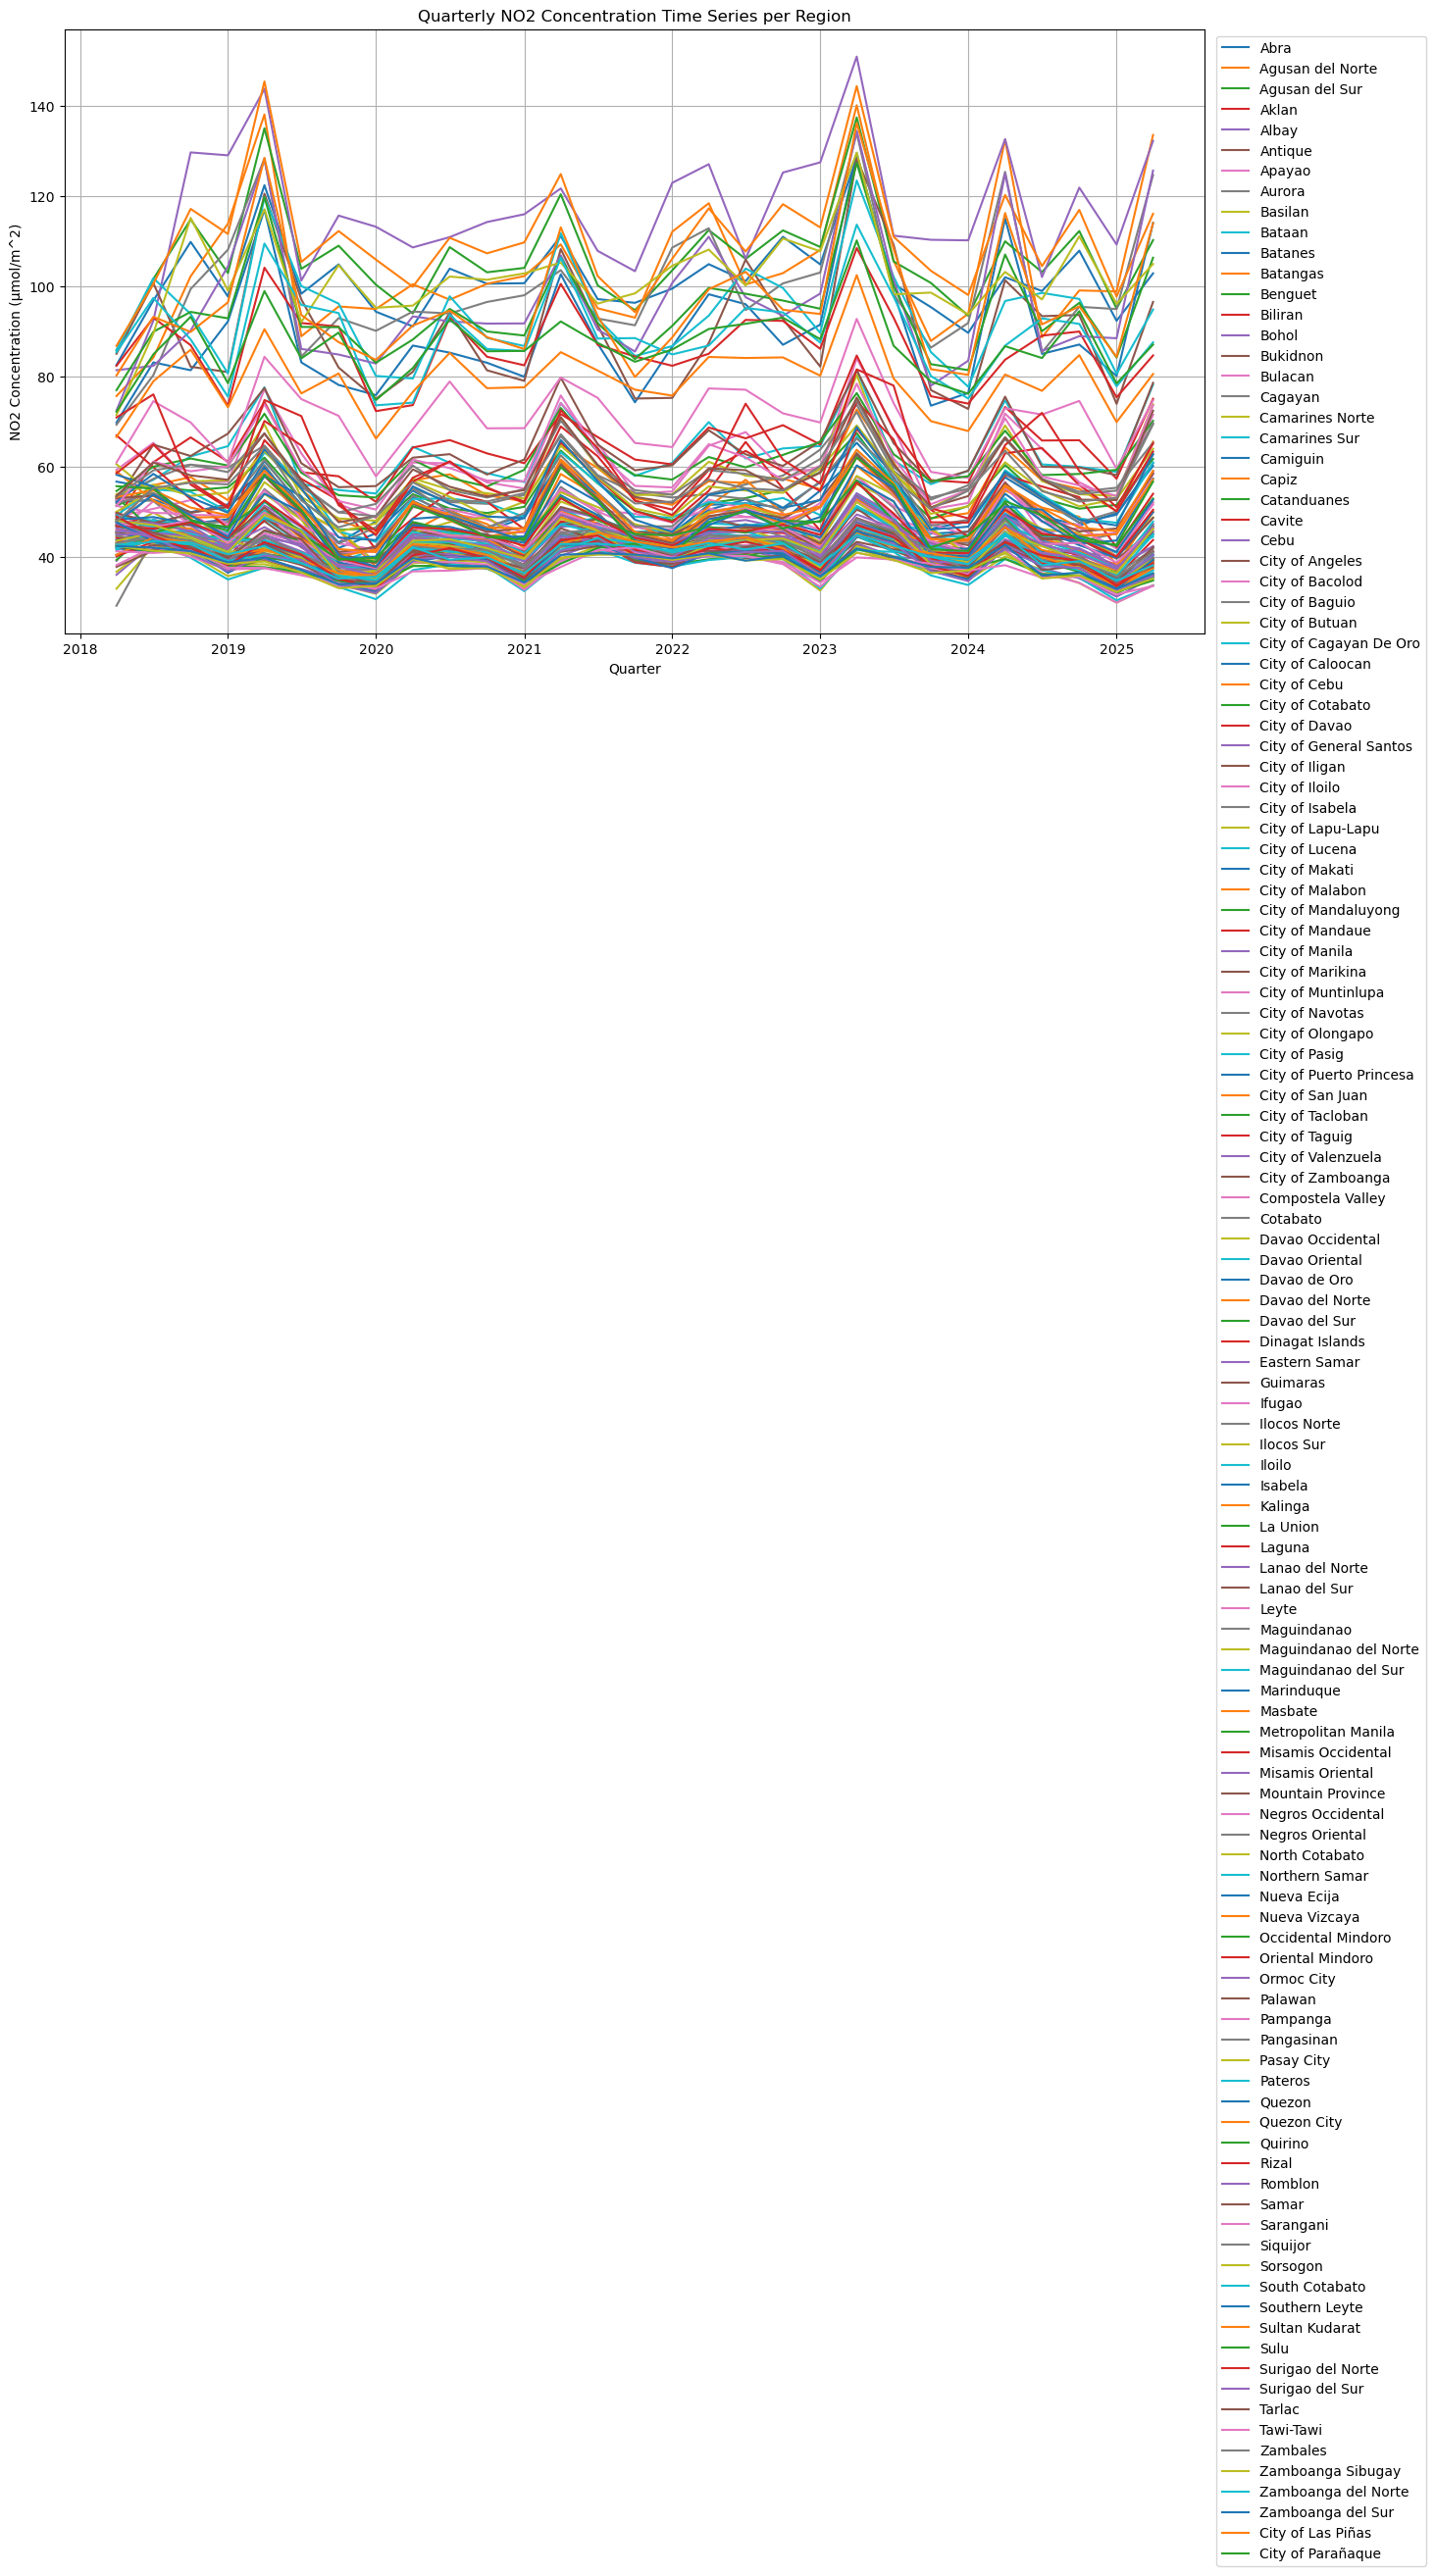

In [20]:
plt.figure(figsize=(15, 8))
for region in df_quarterly['region'].unique():
    region_data = df_quarterly[df_quarterly['region'] == region]
    plt.plot(region_data['quarter'], region_data['NO2_umol_m2'], label=region)

plt.xlabel('Quarter')
plt.ylabel('NO2 Concentration (µmol/m^2)')
plt.title('Quarterly NO2 Concentration Time Series per Region')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

## Validation Checks

Ensure that every expected region (based on geojson filenames) is present in the final dataset:

In [22]:
# Validation: Check if all expected regions from file list are in the dataset
expected_df = pd.read_csv(DATASET_DIR / 'geojson_file_names.csv')  # This CSV should have a column named 'file_name'
normalize = lambda x: unicodedata.normalize('NFKD', str(x)).encode('ascii', 'ignore').decode('utf-8').strip().lower()
clean_string = lambda s: re.sub(r'[^a-z0-9 ]', '', normalize(s))

expected_regions = expected_df['file_name'].apply(clean_string).tolist()
regions_in_df = pd.Series(df_quarterly['region'].unique()).apply(clean_string).tolist()

missing_in_df = [name for name in expected_regions if name not in regions_in_df]
matched_in_df = [name for name in expected_regions if name in regions_in_df]

print("Missing regions:", missing_in_df)
print("Matched regions:", matched_in_df)

Missing regions: ['special geographic area']
Matched regions: ['city of caloocan', 'city of las pinas', 'city of makati', 'city of malabon', 'city of mandaluyong', 'city of manila', 'city of marikina', 'city of muntinlupa', 'city of navotas', 'city of paranaque', 'pasay city', 'city of pasig', 'quezon city', 'city of san juan', 'city of taguig', 'city of valenzuela', 'pateros', 'abra', 'apayao', 'benguet', 'ifugao', 'kalinga', 'mountain province', 'city of baguio', 'ilocos norte', 'ilocos sur', 'la union', 'pangasinan', 'batanes', 'cagayan', 'isabela', 'nueva vizcaya', 'quirino', 'aurora', 'bataan', 'bulacan', 'nueva ecija', 'pampanga', 'tarlac', 'zambales', 'city of angeles', 'city of olongapo', 'batangas', 'cavite', 'laguna', 'quezon', 'rizal', 'city of lucena', 'marinduque', 'occidental mindoro', 'oriental mindoro', 'palawan', 'romblon', 'city of puerto princesa', 'albay', 'camarines norte', 'camarines sur', 'catanduanes', 'masbate', 'sorsogon', 'aklan', 'antique', 'capiz', 'guimara

`special geographic area` was excluded from the final dataset.